# Evaluation of Transfer Learning CNNs for Brain Tumor Diagnosis

# 1. Importing Necessary Libraries

In [49]:
# Standard library imports
import gc
import os
import glob
import random
from collections import Counter

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import (
    efficientnet_b0,
    EfficientNet_B0_Weights,
    mobilenet_v2,
    MobileNet_V2_Weights,
    resnet50,
    ResNet50_Weights,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns


# 2. Data Loading and Visualization

In [50]:
train_path = './dataset/Training'
test_path = './dataset/Testing'

dataset_train = datasets.ImageFolder(root=train_path)
dataset_test = datasets.ImageFolder(root=test_path)

print(f"Training samples: {len(dataset_train)}")
print(f"Testing samples: {len(dataset_test)}")
print(f"Classes: {dataset_train.classes}")

label_indices = [label for _, label in dataset_train.samples]
label_counter = Counter(label_indices)
class_names = dataset_train.classes
class_counts = [label_counter[i] for i in range(len(class_names))]

Training samples: 5712
Testing samples: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 2.1 Data Distribution

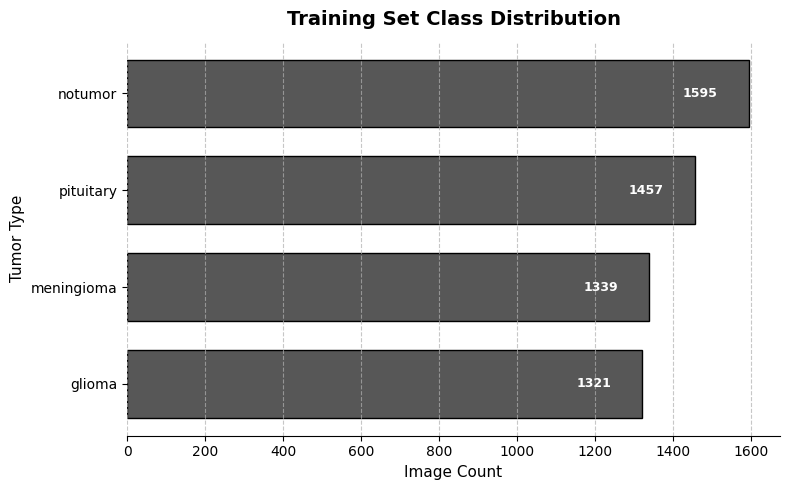

In [51]:
sort_order = np.argsort(class_counts)[::-1]
ordered_classes = [class_names[i] for i in sort_order]
ordered_counts = [class_counts[i] for i in sort_order]

fig, axis = plt.subplots(figsize=(8, 5))
bar_objs = axis.barh(ordered_classes, ordered_counts, color="#575757", edgecolor='black', height=0.7)

for side in ['top', 'right', 'left']:
    axis.spines[side].set_visible(False)

axis.xaxis.grid(True, linestyle='--', alpha=0.7)
axis.yaxis.grid(False)
axis.invert_yaxis()

for bar in bar_objs:
    count = bar.get_width()
    axis.text(count - max(ordered_counts)*0.05, bar.get_y() + bar.get_height()/2,
              f'{int(count)}', ha='right', va='center', color='white', fontsize=9, fontweight='bold')

axis.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold', pad=12)
axis.set_xlabel('Image Count', fontsize=11)
axis.set_ylabel('Tumor Type', fontsize=11)

plt.tight_layout()
plt.show()

## 2.2 MRI Image Visualization

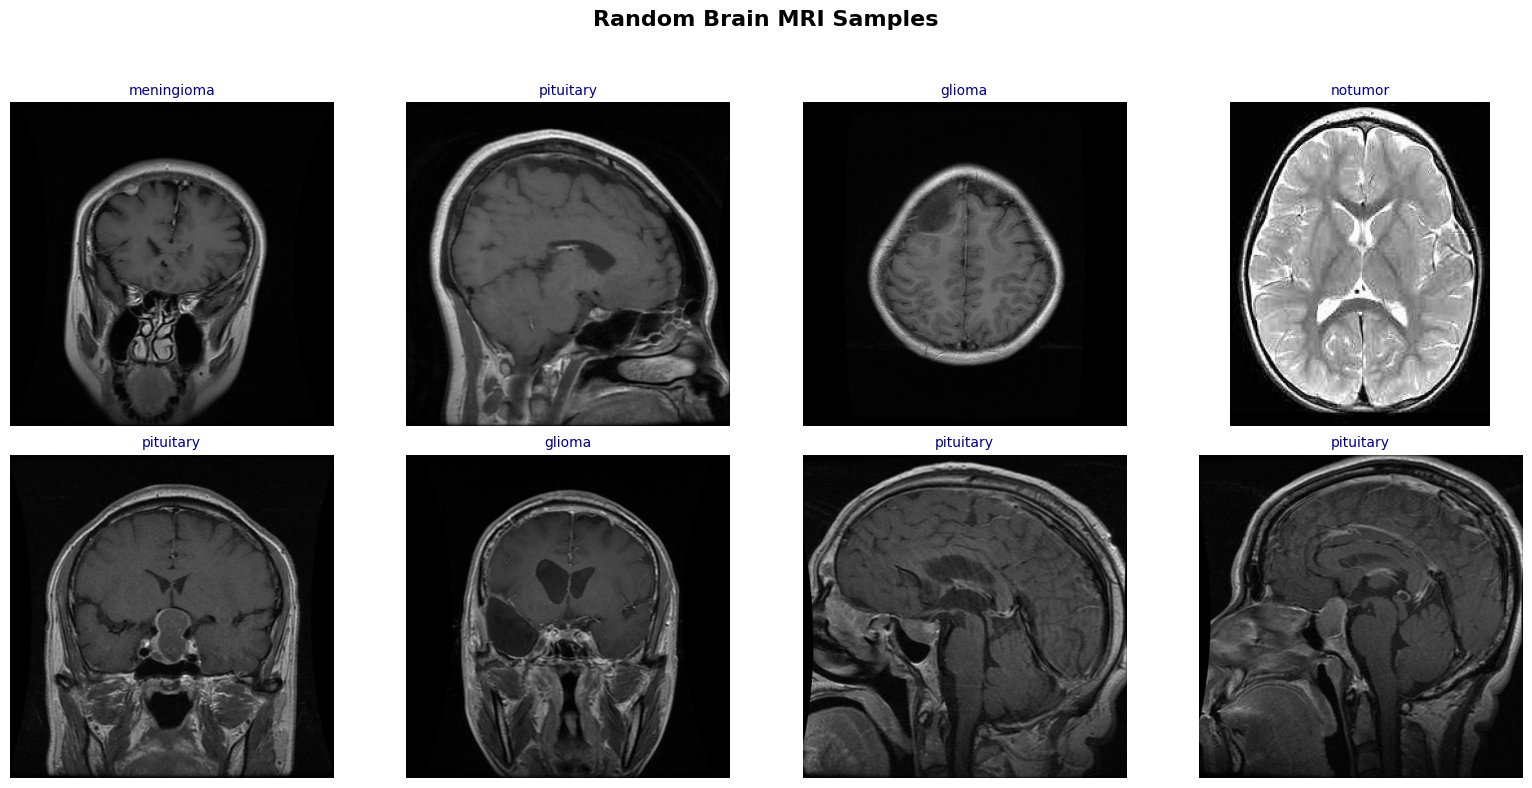

In [52]:
img_paths, img_class_indices = zip(*dataset_train.samples)
img_labels = [dataset_train.classes[idx] for idx in img_class_indices]
rand_indices = random.sample(range(len(img_paths)), 8)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, idx in enumerate(rand_indices):
    image = Image.open(img_paths[idx]).convert('RGB')
    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.set_title(img_labels[idx], fontsize=10, color='darkblue')
    ax.axis('off')

plt.suptitle('Random Brain MRI Samples', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 3. Data Preprocessing

## 3.1 Data Augmentation and Normalization 

In [53]:
img_size = 224
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

augment_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals)
])

augment_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

dataset_train = datasets.ImageFolder(root=train_path, transform=augment_train)
dataset_val = datasets.ImageFolder(root=train_path, transform=augment_test)
dataset_test = datasets.ImageFolder(root=test_path, transform=augment_test)

## 3.2 Splitting Data

In [54]:
split_ratio = 0.8
val_ratio = 0.2

train_idx, val_idx = train_test_split(
    list(range(len(dataset_train))),
    test_size=val_ratio,
    random_state=42,
    stratify=[dataset_train.samples[i][1] for i in range(len(dataset_train))]
)

from torch.utils.data import Subset
train_data = Subset(dataset_train, train_idx)
val_data = Subset(dataset_val, val_idx)

batch_sz = 32
loader_train = DataLoader(train_data, batch_size=batch_sz, shuffle=True, num_workers=4, persistent_workers=True)
loader_val = DataLoader(val_data, batch_size=batch_sz, shuffle=False, num_workers=4, persistent_workers=True)
loader_test = DataLoader(dataset_test, batch_size=batch_sz, shuffle=False, num_workers=4, persistent_workers=True)

# 4. Model Setup

In [55]:
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print(f"Device in use: {device}")

Device in use: cuda


## 4.1 ResNet50

In [56]:
resnet_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model_resnet = resnet_model.to(device)
summary(model_resnet, input_size=(32, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/anshuman/.var/app/com.visualstudio.code/cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:16<00:00, 6.21MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [57]:
for param in model_resnet.parameters():
    param.requires_grad = False
for param in model_resnet.layer4.parameters():
    param.requires_grad = True
num_labels = 4
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_labels)
for param in model_resnet.fc.parameters():
    param.requires_grad = True

## 4.2 EfficientNet-B0

In [58]:
effnet_model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model_effnet = effnet_model.to(device)
summary(model_effnet, input_size=(32, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/anshuman/.var/app/com.visualstudio.code/cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:05<00:00, 3.74MB/s]


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [59]:
num_classes = 4
model_effnet.classifier[1] = nn.Linear(model_effnet.classifier[1].in_features, num_labels)
for param in model_effnet.parameters():
    param.requires_grad = False
for param in model_effnet.classifier.parameters():
    param.requires_grad = True
for param in model_effnet.features[-2].parameters():
    param.requires_grad = True
for param in model_effnet.features[-1].parameters():
    param.requires_grad = True

## 4.3 MobileNetV2

In [60]:
mobilenet_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model_mobilenet = mobilenet_model.to(device)
summary(model_mobilenet, input_size=(32, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /home/anshuman/.var/app/com.visualstudio.code/cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:10<00:00, 1.42MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [32, 1000]                --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                   [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        64
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        --
│    └─InvertedResidual: 2-2                       [32, 16, 112, 112]        --
│    │    └─Sequential: 3-4                        [32, 16, 112, 112]        896
│    └─InvertedResidual: 2-3                       [32, 24, 56, 56]          --
│    │    └─Sequential: 3-5                        [32, 24, 56, 56]          5,136
│    └─InvertedResidual: 2-4                       [32, 24, 56, 56]          --
│    │    └─Sequential: 3-6   

In [61]:
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, num_labels)
for param in model_mobilenet.parameters():
    param.requires_grad = False
for param in model_mobilenet.classifier.parameters():
    param.requires_grad = True
for i in range(-3, 0):
    for param in model_mobilenet.features[i].parameters():
        param.requires_grad = True

# 5. Model Training

In [62]:
def run_one_epoch(net, data_loader, loss_fn, opt, dev):
    net.train()
    total_loss = 0.0
    total_correct = 0
    n_samples = 0
    loop = tqdm(data_loader, desc="Training", leave=True)
    for x, y in loop:
        x = x.to(dev)
        y = y.to(dev)
        opt.zero_grad()
        preds = net(x)
        loss = loss_fn(preds, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
        _, pred_labels = torch.max(preds, 1)
        total_correct += torch.sum(pred_labels == y).item()
        n_samples += x.size(0)
        loop.set_postfix(loss=total_loss / n_samples, accuracy=total_correct / n_samples)
    return total_loss / n_samples, total_correct / n_samples

def validate(net, data_loader, loss_fn, dev):
    net.eval()
    total_loss = 0.0
    total_correct = 0
    n_samples = 0
    with torch.no_grad():
        loop = tqdm(data_loader, desc="Validating", leave=True)
        for x, y in loop:
            x = x.to(dev)
            y = y.to(dev)
            preds = net(x)
            loss = loss_fn(preds, y)
            total_loss += loss.item() * x.size(0)
            _, pred_labels = torch.max(preds, 1)
            total_correct += torch.sum(pred_labels == y).item()
            n_samples += x.size(0)
            loop.set_postfix(loss=total_loss / n_samples, accuracy=total_correct / n_samples)
    return total_loss / n_samples, total_correct / n_samples

In [63]:
def train_and_validate(net, train_loader, val_loader, loss_fn, opt, dev, epochs, save_folder, net_name):
    best_acc = 0.0
    os.makedirs(save_folder, exist_ok=True)
    tr_losses, tr_accs = [], []
    val_losses, val_accs = [], []
    for ep in range(epochs):
        print(f"Epoch {ep+1}/{epochs}")
        tr_loss, tr_acc = run_one_epoch(net, train_loader, loss_fn, opt, dev)
        print(f"Train loss: {tr_loss:.4f}, Train acc: {tr_acc:.4f}")
        val_loss, val_acc = validate(net, val_loader, loss_fn, dev)
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
        tr_losses.append(tr_loss)
        tr_accs.append(tr_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        checkpoint = os.path.join(save_folder, f"{net_name}_epoch_{ep+1}.pth")
        torch.save(net.state_dict(), checkpoint)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = os.path.join(save_folder, f"{net_name}_best.pth")
            torch.save(net.state_dict(), best_model)
            print(f"Best model saved with accuracy: {best_acc:.4f}")
    print(f"Training done. Best validation accuracy: {best_acc:.4f}")
    for ckpt in glob.glob(os.path.join(save_folder, f"{net_name}_epoch_*.pth")):
        try:
            os.remove(ckpt)
        except Exception as e:
            print(f"Error deleting checkpoint {ckpt}: {e}")
    return best_model, tr_losses, tr_accs, val_losses, val_accs

## 5.1 ResNet50

In [64]:
save_folder = "./trained_model/"
net_name = "ResNet50"
model_resnet = model_resnet.to(device)
best_model_resnet, tr_losses_resnet, tr_accs_resnet, val_losses_resnet, val_accs_resnet = train_and_validate(
    net=model_resnet,
    train_loader=loader_train,
    val_loader=loader_val,
    loss_fn=nn.CrossEntropyLoss(),
    opt=optim.Adam(filter(lambda p: p.requires_grad, model_resnet.parameters()), lr=1e-4),
    dev=device,
    epochs=15,
    save_folder=save_folder,
    net_name=net_name
)
print(f"Best model saved at: {best_model_resnet}")

Epoch 1/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.23it/s, accuracy=0.847, loss=0.472]


Train loss: 0.4720, Train acc: 0.8470


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.21it/s, accuracy=0.931, loss=0.288]


Val loss: 0.2878, Val acc: 0.9309
Best model saved with accuracy: 0.9309
Epoch 2/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.25it/s, accuracy=0.941, loss=0.157]


Train loss: 0.1569, Train acc: 0.9409


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.50it/s, accuracy=0.934, loss=0.172]


Val loss: 0.1716, Val acc: 0.9344
Best model saved with accuracy: 0.9344
Epoch 3/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.23it/s, accuracy=0.964, loss=0.102] 


Train loss: 0.1025, Train acc: 0.9637


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.39it/s, accuracy=0.957, loss=0.136]


Val loss: 0.1360, Val acc: 0.9571
Best model saved with accuracy: 0.9571
Epoch 4/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.23it/s, accuracy=0.973, loss=0.0826]


Train loss: 0.0826, Train acc: 0.9726


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.40it/s, accuracy=0.961, loss=0.112]


Val loss: 0.1115, Val acc: 0.9606
Best model saved with accuracy: 0.9606
Epoch 5/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, accuracy=0.977, loss=0.0626]


Train loss: 0.0626, Train acc: 0.9770


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.49it/s, accuracy=0.95, loss=0.146] 


Val loss: 0.1464, Val acc: 0.9501
Epoch 6/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.22it/s, accuracy=0.984, loss=0.0478]


Train loss: 0.0478, Train acc: 0.9842


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.48it/s, accuracy=0.96, loss=0.172] 


Val loss: 0.1718, Val acc: 0.9598
Epoch 7/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.21it/s, accuracy=0.988, loss=0.0354]


Train loss: 0.0354, Train acc: 0.9882


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.44it/s, accuracy=0.967, loss=0.129] 


Val loss: 0.1294, Val acc: 0.9668
Best model saved with accuracy: 0.9668
Epoch 8/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.22it/s, accuracy=0.987, loss=0.0399]


Train loss: 0.0399, Train acc: 0.9866


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.45it/s, accuracy=0.965, loss=0.151] 


Val loss: 0.1509, Val acc: 0.9650
Epoch 9/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.21it/s, accuracy=0.991, loss=0.0311]


Train loss: 0.0311, Train acc: 0.9908


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.50it/s, accuracy=0.972, loss=0.175]


Val loss: 0.1754, Val acc: 0.9720
Best model saved with accuracy: 0.9720
Epoch 10/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.20it/s, accuracy=0.991, loss=0.0253]


Train loss: 0.0253, Train acc: 0.9915


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.50it/s, accuracy=0.973, loss=0.329]


Val loss: 0.3288, Val acc: 0.9729
Best model saved with accuracy: 0.9729
Epoch 11/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.20it/s, accuracy=0.992, loss=0.0267]


Train loss: 0.0267, Train acc: 0.9921


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.45it/s, accuracy=0.971, loss=0.201]


Val loss: 0.2015, Val acc: 0.9711
Epoch 12/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.21it/s, accuracy=0.994, loss=0.021] 


Train loss: 0.0210, Train acc: 0.9943


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.48it/s, accuracy=0.971, loss=0.194] 


Val loss: 0.1939, Val acc: 0.9711
Epoch 13/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, accuracy=0.994, loss=0.02]  


Train loss: 0.0200, Train acc: 0.9937


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.47it/s, accuracy=0.976, loss=0.202] 


Val loss: 0.2016, Val acc: 0.9755
Best model saved with accuracy: 0.9755
Epoch 14/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, accuracy=0.996, loss=0.0146]


Train loss: 0.0146, Train acc: 0.9958


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.47it/s, accuracy=0.976, loss=0.119] 


Val loss: 0.1188, Val acc: 0.9755
Epoch 15/15


Training: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, accuracy=0.995, loss=0.0165]


Train loss: 0.0165, Train acc: 0.9945


Validating: 100%|██████████| 36/36 [00:03<00:00, 10.46it/s, accuracy=0.978, loss=0.204] 


Val loss: 0.2041, Val acc: 0.9781
Best model saved with accuracy: 0.9781
Training done. Best validation accuracy: 0.9781
Best model saved at: ./trained_model/ResNet50_best.pth


## 5.2 EfficientNet-B0

In [65]:
output_dir = "./trained_model/"
network_label = "EffNetB0"
model_effnet = model_effnet.to(device)

best_effnet_path, loss_history_effnet, acc_history_effnet, val_loss_effnet, val_acc_effnet = train_and_validate(
    net=model_effnet,
    train_loader=loader_train,
    val_loader=loader_val,
    loss_fn=nn.CrossEntropyLoss(),
    opt=optim.Adam(filter(lambda p: p.requires_grad, model_effnet.parameters()), lr=1e-4),
    dev=device,
    epochs=15,
    save_folder=output_dir,
    net_name=network_label
)
print(f"Best EfficientNet-B0 model stored at: {best_effnet_path}")

Epoch 1/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.51it/s, accuracy=0.783, loss=0.691]


Train loss: 0.6907, Train acc: 0.7833


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.84it/s, accuracy=0.89, loss=0.359] 


Val loss: 0.3588, Val acc: 0.8898
Best model saved with accuracy: 0.8898
Epoch 2/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.58it/s, accuracy=0.884, loss=0.34] 


Train loss: 0.3397, Train acc: 0.8842


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.62it/s, accuracy=0.909, loss=0.266]


Val loss: 0.2663, Val acc: 0.9090
Best model saved with accuracy: 0.9090
Epoch 3/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.55it/s, accuracy=0.904, loss=0.271]


Train loss: 0.2711, Train acc: 0.9039


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.99it/s, accuracy=0.922, loss=0.225]


Val loss: 0.2255, Val acc: 0.9221
Best model saved with accuracy: 0.9221
Epoch 4/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.73it/s, accuracy=0.915, loss=0.237]


Train loss: 0.2374, Train acc: 0.9153


Validating: 100%|██████████| 36/36 [00:01<00:00, 23.06it/s, accuracy=0.928, loss=0.197]


Val loss: 0.1968, Val acc: 0.9283
Best model saved with accuracy: 0.9283
Epoch 5/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.74it/s, accuracy=0.929, loss=0.201]


Train loss: 0.2007, Train acc: 0.9293


Validating: 100%|██████████| 36/36 [00:01<00:00, 23.12it/s, accuracy=0.938, loss=0.167]


Val loss: 0.1672, Val acc: 0.9379
Best model saved with accuracy: 0.9379
Epoch 6/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.66it/s, accuracy=0.936, loss=0.181]


Train loss: 0.1812, Train acc: 0.9363


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.84it/s, accuracy=0.943, loss=0.155]


Val loss: 0.1547, Val acc: 0.9431
Best model saved with accuracy: 0.9431
Epoch 7/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.70it/s, accuracy=0.941, loss=0.16] 


Train loss: 0.1602, Train acc: 0.9413


Validating: 100%|██████████| 36/36 [00:01<00:00, 23.08it/s, accuracy=0.947, loss=0.145]


Val loss: 0.1453, Val acc: 0.9466
Best model saved with accuracy: 0.9466
Epoch 8/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.68it/s, accuracy=0.951, loss=0.146]


Train loss: 0.1459, Train acc: 0.9505


Validating: 100%|██████████| 36/36 [00:01<00:00, 23.15it/s, accuracy=0.948, loss=0.133]


Val loss: 0.1331, Val acc: 0.9484
Best model saved with accuracy: 0.9484
Epoch 9/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.72it/s, accuracy=0.952, loss=0.135]


Train loss: 0.1346, Train acc: 0.9518


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.89it/s, accuracy=0.949, loss=0.136]


Val loss: 0.1360, Val acc: 0.9493
Best model saved with accuracy: 0.9493
Epoch 10/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.61it/s, accuracy=0.95, loss=0.137] 


Train loss: 0.1371, Train acc: 0.9503


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.78it/s, accuracy=0.958, loss=0.115]


Val loss: 0.1153, Val acc: 0.9580
Best model saved with accuracy: 0.9580
Epoch 11/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.79it/s, accuracy=0.959, loss=0.118]


Train loss: 0.1178, Train acc: 0.9591


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.77it/s, accuracy=0.954, loss=0.127]


Val loss: 0.1266, Val acc: 0.9536
Epoch 12/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.74it/s, accuracy=0.961, loss=0.107]


Train loss: 0.1073, Train acc: 0.9610


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.87it/s, accuracy=0.959, loss=0.108]


Val loss: 0.1076, Val acc: 0.9589
Best model saved with accuracy: 0.9589
Epoch 13/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.57it/s, accuracy=0.962, loss=0.106]


Train loss: 0.1055, Train acc: 0.9619


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.87it/s, accuracy=0.959, loss=0.104] 


Val loss: 0.1036, Val acc: 0.9589
Epoch 14/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.74it/s, accuracy=0.963, loss=0.0995]


Train loss: 0.0995, Train acc: 0.9630


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.97it/s, accuracy=0.965, loss=0.0904]


Val loss: 0.0904, Val acc: 0.9650
Best model saved with accuracy: 0.9650
Epoch 15/15


Training: 100%|██████████| 143/143 [00:07<00:00, 19.69it/s, accuracy=0.969, loss=0.0847]


Train loss: 0.0847, Train acc: 0.9689


Validating: 100%|██████████| 36/36 [00:01<00:00, 22.69it/s, accuracy=0.964, loss=0.0949]


Val loss: 0.0949, Val acc: 0.9641
Training done. Best validation accuracy: 0.9650
Best EfficientNet-B0 model stored at: ./trained_model/EffNetB0_best.pth


## 5.3 MobileNetV2

In [66]:
output_dir = "./trained_model/"
network_label = "MobileNetV2"
model_mobilenet = model_mobilenet.to(device)

best_mobilenet_path, loss_history_mobilenet, acc_history_mobilenet, val_loss_mobilenet, val_acc_mobilenet = train_and_validate(
    net=model_mobilenet,
    train_loader=loader_train,
    val_loader=loader_val,
    loss_fn=nn.CrossEntropyLoss(),
    opt=optim.Adam(filter(lambda p: p.requires_grad, model_mobilenet.parameters()), lr=1e-4),
    dev=device,
    epochs=15,
    save_folder=output_dir,
    net_name=network_label
)
print(f"Best MobileNetV2 model stored at: {best_mobilenet_path}")

Epoch 1/15


Training: 100%|██████████| 143/143 [00:06<00:00, 21.75it/s, accuracy=0.784, loss=0.728]


Train loss: 0.7282, Train acc: 0.7844


Validating: 100%|██████████| 36/36 [00:01<00:00, 26.83it/s, accuracy=0.892, loss=0.378]


Val loss: 0.3778, Val acc: 0.8915
Best model saved with accuracy: 0.8915
Epoch 2/15


Training: 100%|██████████| 143/143 [00:06<00:00, 21.97it/s, accuracy=0.892, loss=0.329]


Train loss: 0.3292, Train acc: 0.8923


Validating: 100%|██████████| 36/36 [00:01<00:00, 27.13it/s, accuracy=0.901, loss=0.288]


Val loss: 0.2877, Val acc: 0.9011
Best model saved with accuracy: 0.9011
Epoch 3/15


Training: 100%|██████████| 143/143 [00:06<00:00, 22.03it/s, accuracy=0.908, loss=0.258]


Train loss: 0.2575, Train acc: 0.9076


Validating: 100%|██████████| 36/36 [00:01<00:00, 27.59it/s, accuracy=0.906, loss=0.233]


Val loss: 0.2326, Val acc: 0.9055
Best model saved with accuracy: 0.9055
Epoch 4/15


Training: 100%|██████████| 143/143 [00:06<00:00, 22.01it/s, accuracy=0.921, loss=0.22] 


Train loss: 0.2201, Train acc: 0.9208


Validating: 100%|██████████| 36/36 [00:01<00:00, 28.00it/s, accuracy=0.927, loss=0.19] 


Val loss: 0.1904, Val acc: 0.9265
Best model saved with accuracy: 0.9265
Epoch 5/15


Training: 100%|██████████| 143/143 [00:06<00:00, 21.91it/s, accuracy=0.932, loss=0.183]


Train loss: 0.1830, Train acc: 0.9324


Validating: 100%|██████████| 36/36 [00:01<00:00, 27.60it/s, accuracy=0.941, loss=0.175]


Val loss: 0.1754, Val acc: 0.9414
Best model saved with accuracy: 0.9414
Epoch 6/15


Training: 100%|██████████| 143/143 [00:06<00:00, 21.94it/s, accuracy=0.944, loss=0.161]


Train loss: 0.1611, Train acc: 0.9438


Validating: 100%|██████████| 36/36 [00:01<00:00, 27.85it/s, accuracy=0.94, loss=0.163] 


Val loss: 0.1629, Val acc: 0.9396
Epoch 7/15


Training: 100%|██████████| 143/143 [00:06<00:00, 21.91it/s, accuracy=0.952, loss=0.132]


Train loss: 0.1316, Train acc: 0.9518


Validating: 100%|██████████| 36/36 [00:01<00:00, 27.38it/s, accuracy=0.949, loss=0.144]


Val loss: 0.1440, Val acc: 0.9493
Best model saved with accuracy: 0.9493
Epoch 8/15


Training: 100%|██████████| 143/143 [00:06<00:00, 21.95it/s, accuracy=0.957, loss=0.126]


Train loss: 0.1256, Train acc: 0.9573


Validating: 100%|██████████| 36/36 [00:01<00:00, 27.63it/s, accuracy=0.948, loss=0.143]


Val loss: 0.1432, Val acc: 0.9475
Epoch 9/15


Training: 100%|██████████| 143/143 [00:06<00:00, 21.80it/s, accuracy=0.962, loss=0.113]


Train loss: 0.1134, Train acc: 0.9624


Validating: 100%|██████████| 36/36 [00:01<00:00, 28.60it/s, accuracy=0.956, loss=0.12] 


Val loss: 0.1204, Val acc: 0.9563
Best model saved with accuracy: 0.9563
Epoch 10/15


Training: 100%|██████████| 143/143 [00:06<00:00, 23.06it/s, accuracy=0.96, loss=0.107] 


Train loss: 0.1069, Train acc: 0.9595


Validating: 100%|██████████| 36/36 [00:01<00:00, 28.95it/s, accuracy=0.952, loss=0.129]


Val loss: 0.1291, Val acc: 0.9519
Epoch 11/15


Training: 100%|██████████| 143/143 [00:06<00:00, 23.19it/s, accuracy=0.966, loss=0.0995]


Train loss: 0.0995, Train acc: 0.9659


Validating: 100%|██████████| 36/36 [00:01<00:00, 29.27it/s, accuracy=0.952, loss=0.132]


Val loss: 0.1324, Val acc: 0.9519
Epoch 12/15


Training: 100%|██████████| 143/143 [00:06<00:00, 23.15it/s, accuracy=0.968, loss=0.0876]


Train loss: 0.0876, Train acc: 0.9685


Validating: 100%|██████████| 36/36 [00:01<00:00, 29.13it/s, accuracy=0.963, loss=0.103]


Val loss: 0.1027, Val acc: 0.9633
Best model saved with accuracy: 0.9633
Epoch 13/15


Training: 100%|██████████| 143/143 [00:06<00:00, 23.05it/s, accuracy=0.97, loss=0.0792] 


Train loss: 0.0792, Train acc: 0.9702


Validating: 100%|██████████| 36/36 [00:01<00:00, 28.91it/s, accuracy=0.962, loss=0.117]


Val loss: 0.1171, Val acc: 0.9624
Epoch 14/15


Training: 100%|██████████| 143/143 [00:06<00:00, 23.18it/s, accuracy=0.976, loss=0.0747]


Train loss: 0.0747, Train acc: 0.9764


Validating: 100%|██████████| 36/36 [00:01<00:00, 29.01it/s, accuracy=0.956, loss=0.13] 


Val loss: 0.1303, Val acc: 0.9563
Epoch 15/15


Training: 100%|██████████| 143/143 [00:06<00:00, 23.09it/s, accuracy=0.976, loss=0.0729]


Train loss: 0.0729, Train acc: 0.9761


Validating: 100%|██████████| 36/36 [00:01<00:00, 28.97it/s, accuracy=0.966, loss=0.108]


Val loss: 0.1084, Val acc: 0.9659
Best model saved with accuracy: 0.9659
Training done. Best validation accuracy: 0.9659
Best MobileNetV2 model stored at: ./trained_model/MobileNetV2_best.pth


## 5.4 Visualizing Model Performance

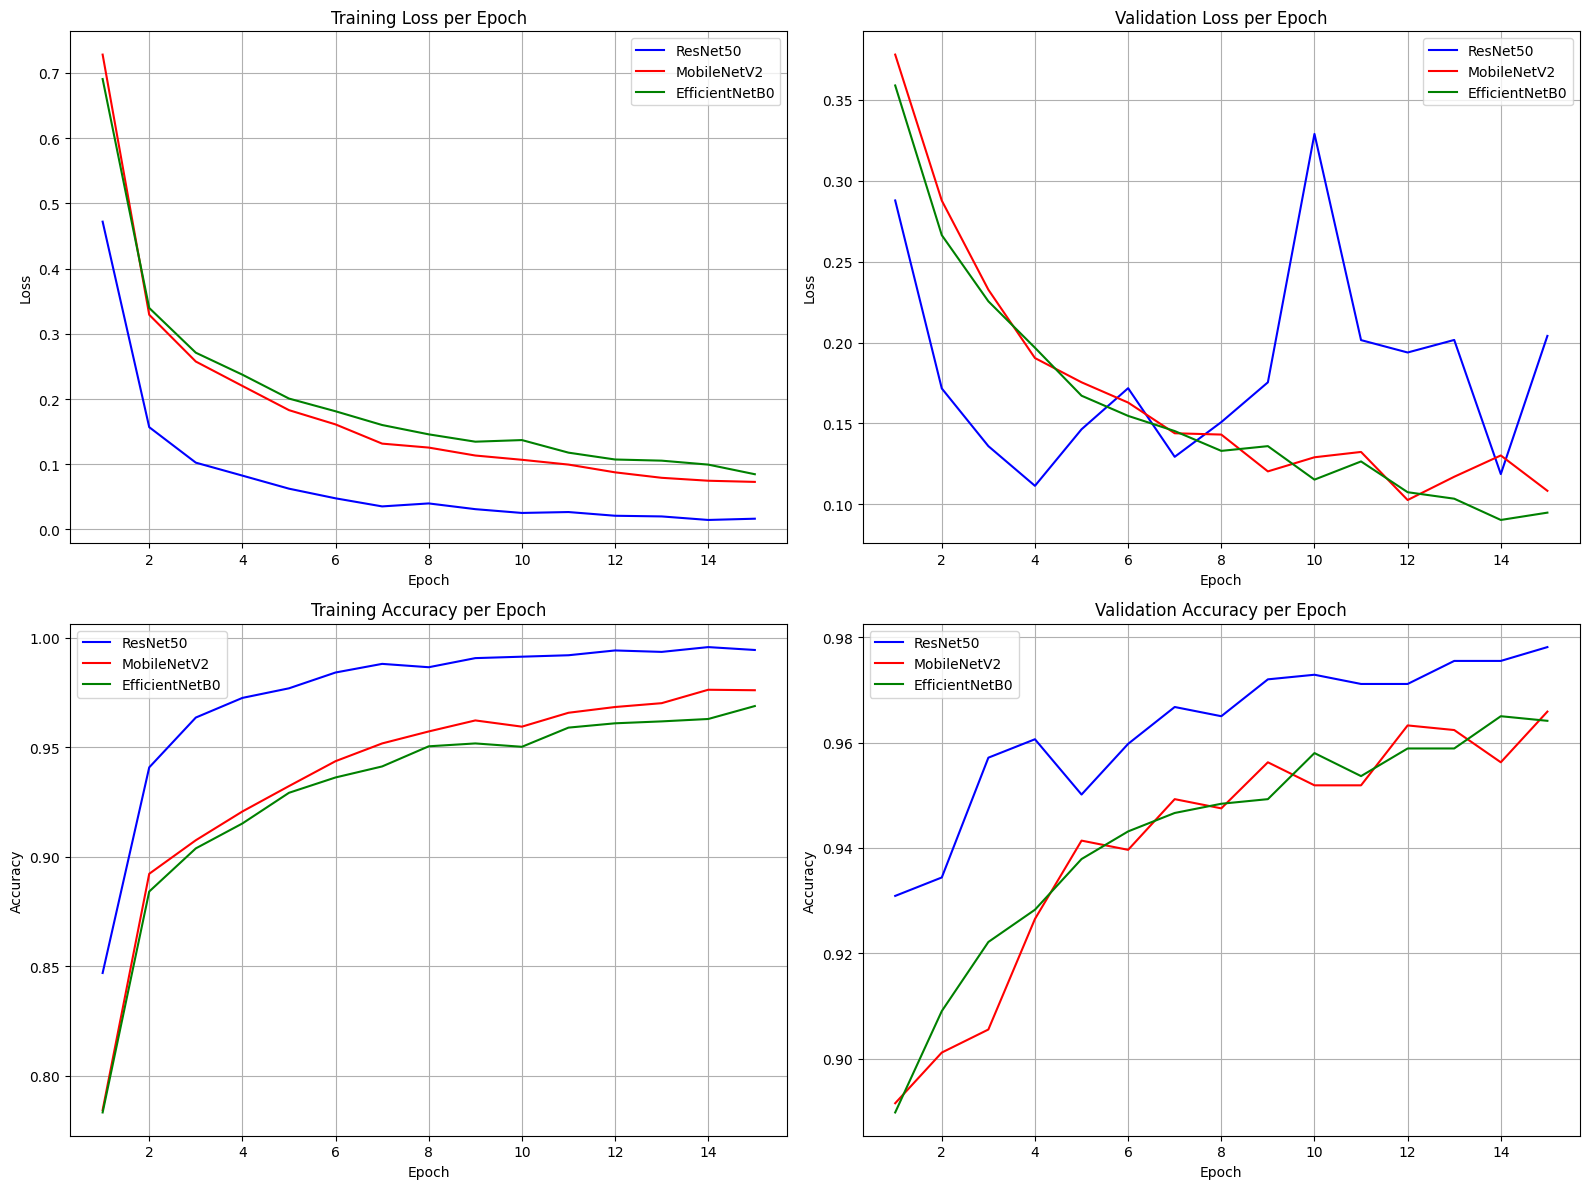

In [67]:
# Prepare epoch range based on ResNet50 training history
epoch_range = range(1, len(tr_losses_resnet) + 1)

plt.figure(figsize=(16, 12))

# --- Training Loss ---
plt.subplot(2, 2, 1)
plt.plot(epoch_range, tr_losses_resnet, 'b-', label='ResNet50')
plt.plot(epoch_range, loss_history_mobilenet, 'r-', label='MobileNetV2')
plt.plot(epoch_range, loss_history_effnet, 'g-', label='EfficientNetB0')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Validation Loss ---
plt.subplot(2, 2, 2)
plt.plot(epoch_range, val_losses_resnet, 'b-', label='ResNet50')
plt.plot(epoch_range, val_loss_mobilenet, 'r-', label='MobileNetV2')
plt.plot(epoch_range, val_loss_effnet, 'g-', label='EfficientNetB0')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Training Accuracy ---
plt.subplot(2, 2, 3)
plt.plot(epoch_range, tr_accs_resnet, 'b-', label='ResNet50')
plt.plot(epoch_range, acc_history_mobilenet, 'r-', label='MobileNetV2')
plt.plot(epoch_range, acc_history_effnet, 'g-', label='EfficientNetB0')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Validation Accuracy ---
plt.subplot(2, 2, 4)
plt.plot(epoch_range, val_accs_resnet, 'b-', label='ResNet50')
plt.plot(epoch_range, val_acc_mobilenet, 'r-', label='MobileNetV2')
plt.plot(epoch_range, val_acc_effnet, 'g-', label='EfficientNetB0')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 6. Testing, Evaluation and Comparison

## 6.1 Testing

In [68]:
def test_model(net, test_loader, loss_fn, dev):
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(dev), y.to(dev)
            out = net(x)
            loss = loss_fn(out, y)
            test_loss += loss.item() * x.size(0)
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    avg_loss = test_loss / total
    accuracy = correct / total
    return avg_loss, accuracy, preds_all, labels_all

In [69]:
def evaluate_model_on_test(model, model_path, loader, criterion, device, class_names, model_label):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_loss, test_acc, preds, labels = test_model(model, loader, criterion, device)
    print(f"{model_label} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"{model_label} - Classification Report:")
    print(classification_report(labels, preds, digits=4, target_names=class_names))
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_label} - Confusion Matrix')
    plt.show()
    return test_loss, test_acc

### 6.1.1 ResNet50

ResNet50 - Test Loss: 0.2130, Test Accuracy: 0.9855
ResNet50 - Classification Report:
              precision    recall  f1-score   support

      glioma     0.9865    0.9767    0.9816       300
  meningioma     0.9645    0.9771    0.9708       306
     notumor     0.9975    0.9901    0.9938       405
   pituitary     0.9901    0.9967    0.9934       300

    accuracy                         0.9855      1311
   macro avg     0.9847    0.9851    0.9849      1311
weighted avg     0.9856    0.9855    0.9855      1311



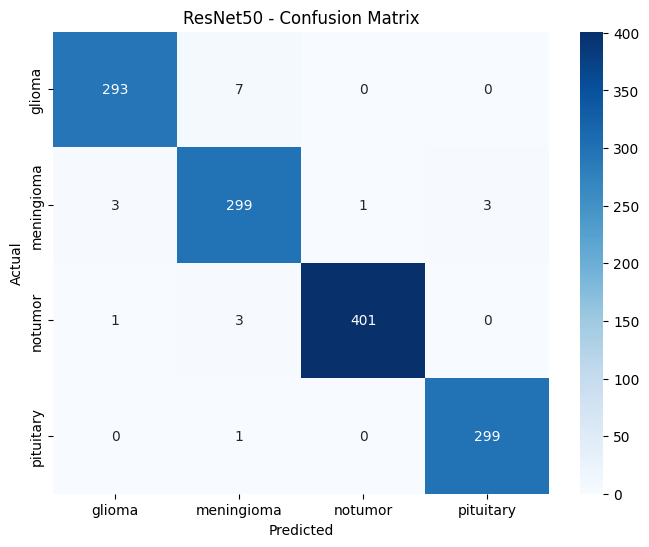

In [70]:
criterion = nn.CrossEntropyLoss()
class_names = dataset_train.classes
test_loss_resnet, test_acc_resnet = evaluate_model_on_test(
    model_resnet, best_model_resnet, loader_test, criterion, device, class_names, "ResNet50"
)

### 6.1.2 EfficientNet-B0

EfficientNet-B0 - Test Loss: 0.0974, Test Accuracy: 0.9695
EfficientNet-B0 - Classification Report:
              precision    recall  f1-score   support

      glioma     0.9859    0.9333    0.9589       300
  meningioma     0.9353    0.9444    0.9398       306
     notumor     0.9806    0.9975    0.9890       405
   pituitary     0.9739    0.9933    0.9835       300

    accuracy                         0.9695      1311
   macro avg     0.9689    0.9672    0.9678      1311
weighted avg     0.9697    0.9695    0.9694      1311



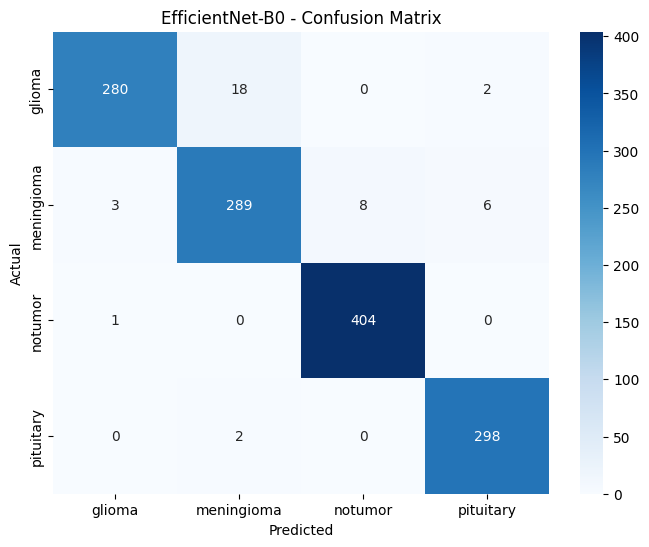

In [71]:
test_loss_effnet, test_acc_effnet = evaluate_model_on_test(
    model_effnet, best_effnet_path, loader_test, criterion, device, class_names, "EfficientNet-B0"
)

### 6.1.3 MobileNetV2

MobileNetV2 - Test Loss: 0.1014, Test Accuracy: 0.9672
MobileNetV2 - Classification Report:
              precision    recall  f1-score   support

      glioma     0.9824    0.9300    0.9555       300
  meningioma     0.9204    0.9444    0.9323       306
     notumor     0.9735    0.9975    0.9854       405
   pituitary     0.9933    0.9867    0.9900       300

    accuracy                         0.9672      1311
   macro avg     0.9674    0.9647    0.9658      1311
weighted avg     0.9677    0.9672    0.9672      1311



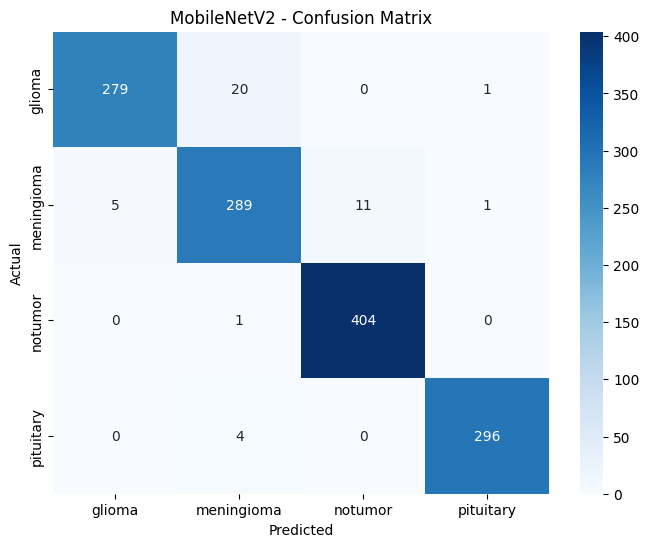

In [72]:
test_loss_mobilenet, test_acc_mobilenet = evaluate_model_on_test(
    model_mobilenet, best_mobilenet_path, loader_test, criterion, device, class_names, "MobileNetV2"
)

## 6.2 Comparison

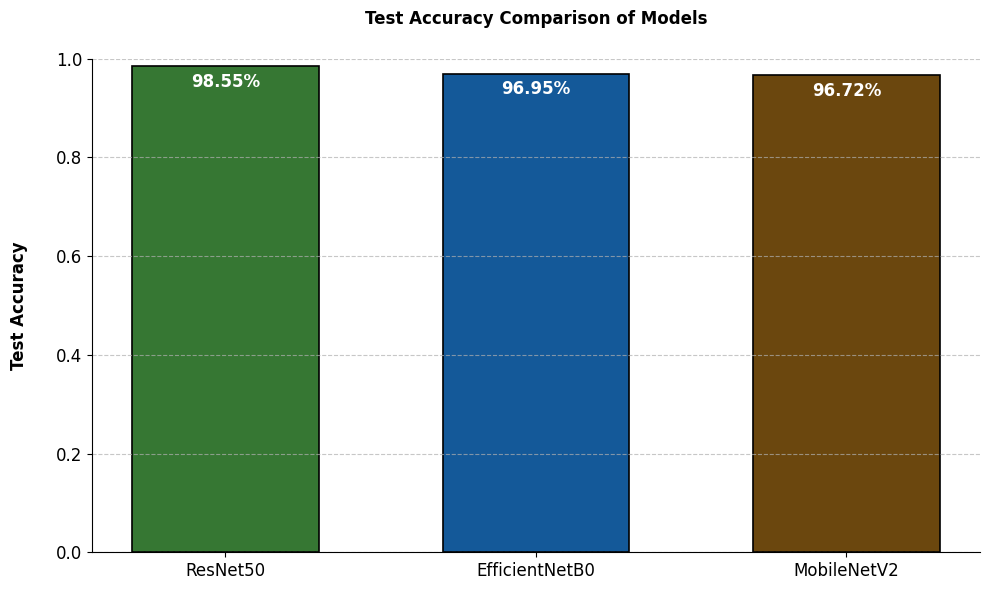

In [73]:
# Prepare model names and their corresponding test accuracies
model_names = ['ResNet50', 'EfficientNetB0', 'MobileNetV2']
test_accuracies = [test_acc_resnet, test_acc_effnet, test_acc_mobilenet]

bar_colors = ["#367733", "#145999", "#6B470E"]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, test_accuracies, color=bar_colors, edgecolor='black', linewidth=1.2, width=0.6)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, color in zip(bars, bar_colors):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.05, f'{height:.2%}',
             ha='center', va='bottom', color='white', fontweight='bold', fontsize=12)

plt.ylabel('Test Accuracy', fontsize=12, fontweight='bold', labelpad=20)
plt.title('Test Accuracy Comparison of Models', fontsize=12, fontweight='bold', pad=25)

plt.tight_layout()
plt.show()

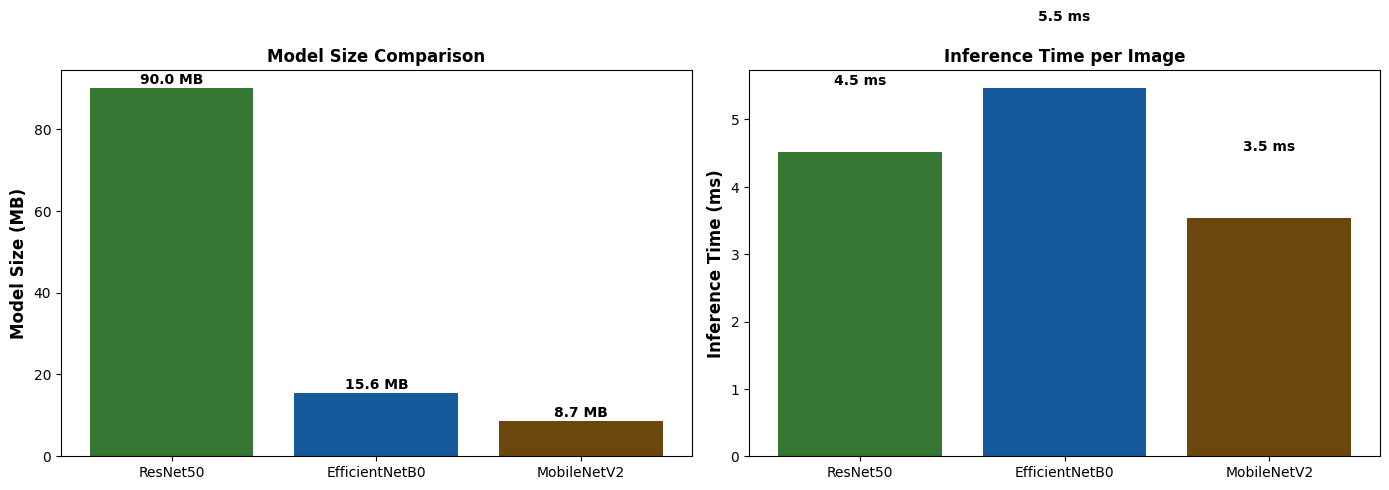

In [74]:
import time
import os
import torch

def get_model_size(model_path):
    size_bytes = os.path.getsize(model_path)
    return size_bytes / (1024 * 1024)  # Convert to MB

def measure_inference_time(model, device, input_shape=(1, 3, 224, 224), n_runs=100):
    model.eval()
    dummy_input = torch.randn(input_shape).to(device)
    with torch.no_grad():
        # Warm-up
        for _ in range(10):
            _ = model(dummy_input)
        # Timing
        start = time.time()
        for _ in range(n_runs):
            _ = model(dummy_input)
        end = time.time()
    avg_time_ms = ((end - start) / n_runs) * 1000
    return avg_time_ms

# Model paths
model_paths = [best_model_resnet, best_effnet_path, best_mobilenet_path]
models = [model_resnet, model_effnet, model_mobilenet]
model_labels = ['ResNet50', 'EfficientNetB0', 'MobileNetV2']

# Model size
model_sizes = [get_model_size(p) for p in model_paths]

# Inference time
inference_times = [measure_inference_time(m.to(device), device) for m in models]

# (Optional) If you have tracked training time per epoch, add it here as a list:
# training_times = [resnet_time, effnet_time, mobilenet_time]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model size
axes[0].bar(model_labels, model_sizes, color=bar_colors)
axes[0].set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Size Comparison', fontsize=12, fontweight='bold')
for i, v in enumerate(model_sizes):
    axes[0].text(i, v + 1, f"{v:.1f} MB", ha='center', color='black', fontweight='bold')

# Inference time
axes[1].bar(model_labels, inference_times, color=bar_colors)
axes[1].set_ylabel('Inference Time (ms)', fontsize=12, fontweight='bold')
axes[1].set_title('Inference Time per Image', fontsize=12, fontweight='bold')
for i, v in enumerate(inference_times):
    axes[1].text(i, v + 1, f"{v:.1f} ms", ha='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

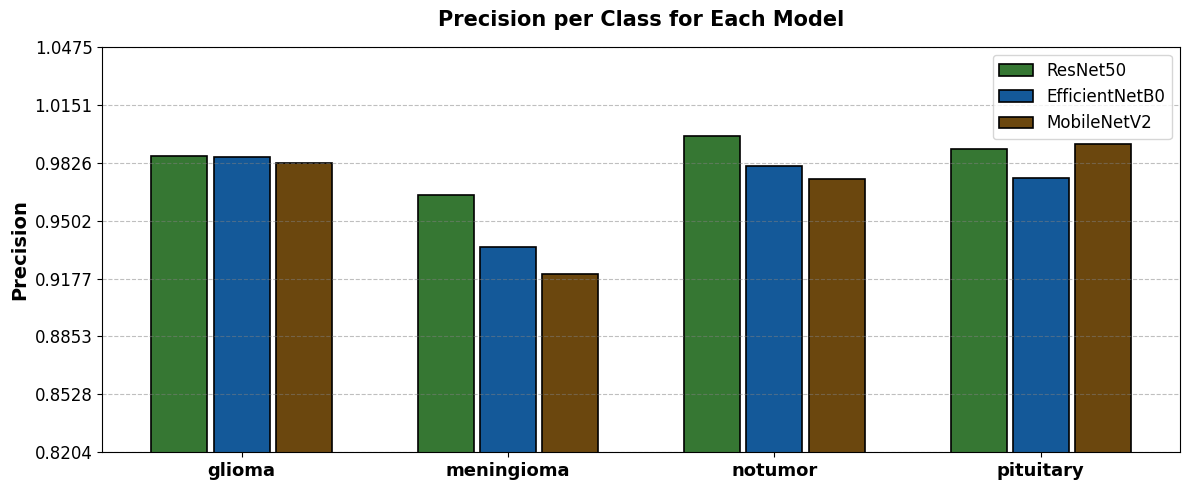

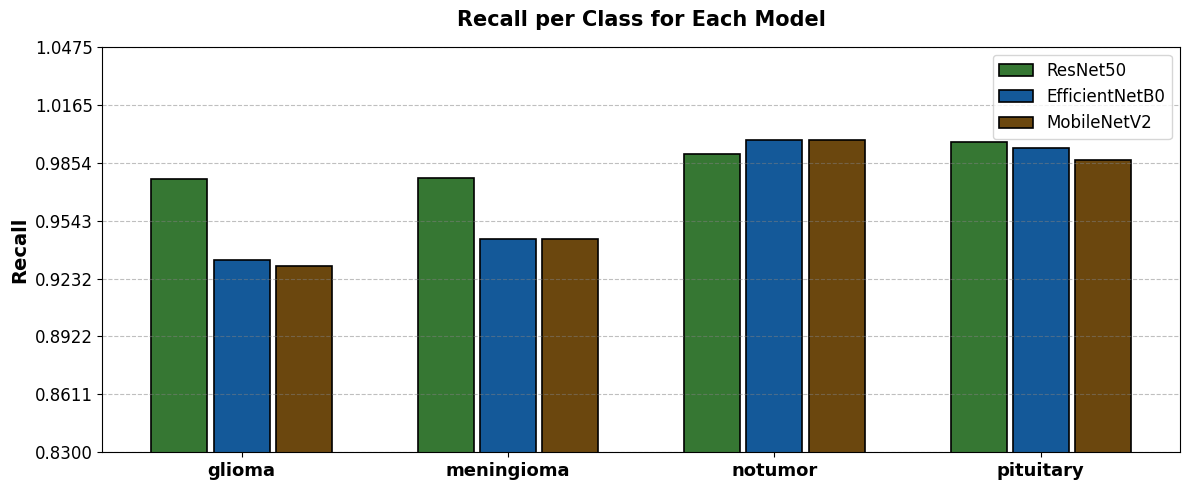

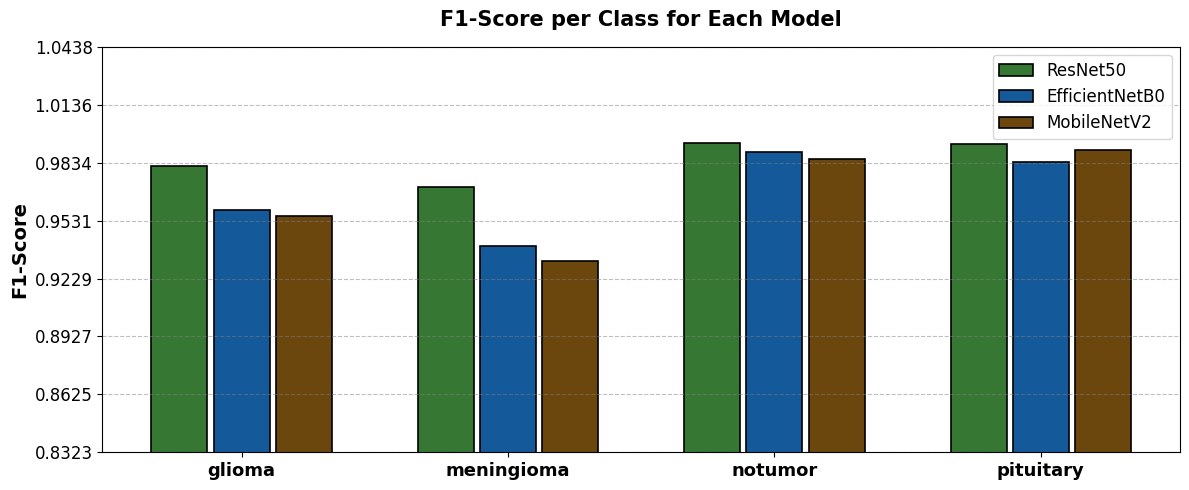

In [75]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Get predictions and labels for each model
_, _, preds_resnet, labels_resnet = test_model(model_resnet, loader_test, nn.CrossEntropyLoss(), device)
_, _, preds_effnet, labels_effnet = test_model(model_effnet, loader_test, nn.CrossEntropyLoss(), device)
_, _, preds_mobilenet, labels_mobilenet = test_model(model_mobilenet, loader_test, nn.CrossEntropyLoss(), device)

# Compute metrics
prec_resnet, rec_resnet, f1_resnet, _ = precision_recall_fscore_support(labels_resnet, preds_resnet, labels=range(len(class_names)))
prec_effnet, rec_effnet, f1_effnet, _ = precision_recall_fscore_support(labels_effnet, preds_effnet, labels=range(len(class_names)))
prec_mobilenet, rec_mobilenet, f1_mobilenet, _ = precision_recall_fscore_support(labels_mobilenet, preds_mobilenet, labels=range(len(class_names)))

metrics = {
    'Precision': [prec_resnet, prec_effnet, prec_mobilenet],
    'Recall':    [rec_resnet, rec_effnet, rec_mobilenet],
    'F1-Score':  [f1_resnet, f1_effnet, f1_mobilenet]
}
model_labels = ['ResNet50', 'EfficientNetB0', 'MobileNetV2']
bar_colors = ["#367733", "#145999", "#6B470E"]

x = np.arange(len(class_names))

for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(12, 5))
    n_models = len(model_labels)
    total_width = 0.7  # total width for all bars at one x location
    single_width = total_width / n_models
    offsets = np.linspace(-total_width/2 + single_width/2, total_width/2 - single_width/2, n_models)
    bar_containers = []
    for i, (vals, color) in enumerate(zip(metric_values, bar_colors)):
        bars = plt.bar(x + offsets[i], vals, single_width*0.9, label=model_labels[i], color=color, edgecolor='black', linewidth=1.2)
        bar_containers.append(bars)
    plt.xticks(x, class_names, fontsize=13, fontweight='bold')

    # Set y-limits to zoom in on the range of your metrics for better visibility
    min_metric = min([min(vals) for vals in metric_values])
    max_metric = max([max(vals) for vals in metric_values])
    y_min = max(0, min_metric - 0.1)
    y_max = min(1.05, max_metric + 0.05)
    if y_max - y_min < 0.2:  # Ensure a minimum range for visibility
        y_max = min(1.05, y_min + 0.2)
    plt.ylim(y_min, y_max)
    plt.yticks(np.linspace(y_min, y_max, num=8), fontsize=12)

    plt.ylabel(metric_name, fontsize=14, fontweight='bold')
    plt.title(f'{metric_name} per Class for Each Model', fontsize=15, fontweight='bold', pad=15)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5, zorder=0)
    plt.tight_layout()
    # Annotate bars inside, towards the top
    for bars in bar_containers:
        for bar in bars:
            height = bar.get_height()
            
    plt.show()